In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
import pandas as pd
from codex import io as codex_io
from codex import config as codex_config
from skimage import exposure
from skimage import io as sk_io
plt.gray()
None

In [2]:
exp_name = '7-7-17-multicycle'
exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-cytokit', 'output', 'v01')
nuc_cyc = 0
nuc_ch = 0
nuc_ch_name = 'ch:HOECHST1'

# exp_name = '20180706-Donor22-R2-Tcell-CODEX_CD3CD4CD85BY5'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01')
# nuc_cyc = 0
# nuc_ch = 0
# nuc_ch_name = 'ch:DAPI'

In [3]:
#img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'hoechst'))
img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'best_z_segm'))
img_path

'/lab/data/7-7-17-multicycle-cytokit/output/v01/montage/best_z_segm/R001.tif'

In [4]:
img = codex_io.read_tile(img_path)
img.shape

(1, 1, 9, 5040, 6720)

In [5]:
df = pd.read_csv(osp.join(exp_data_dir, codex_io.get_cytometry_agg_path('csv')))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81107 entries, 0 to 81106
Data columns (total 49 columns):
region_index        81107 non-null int64
tile_index          81107 non-null int64
tile_x              81107 non-null int64
tile_y              81107 non-null int64
rid                 81107 non-null int64
rx                  81107 non-null float64
ry                  81107 non-null float64
id                  81107 non-null int64
x                   81107 non-null float64
y                   81107 non-null float64
z                   81107 non-null int64
cell_size           81107 non-null float64
cell_diameter       81107 non-null float64
cell_solidity       81107 non-null float64
nucleus_size        81107 non-null float64
nucleus_diameter    81107 non-null float64
nucleus_solidity    81107 non-null float64
ch:HOECHST1         81107 non-null float64
ch:CollagenIV       81107 non-null float64
ch:CD7              81107 non-null float64
ch:Ki67             81107 non-null float64
ch

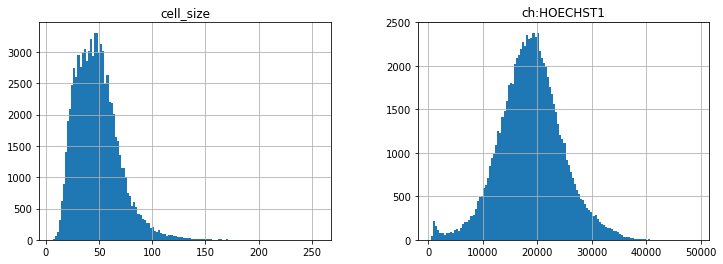

In [6]:
df[['cell_size', nuc_ch_name]].hist(figsize=(12, 4), bins=128)
None

In [9]:
from sklearn.preprocessing import PolynomialFeatures

def add_features(X):
#     X['rx2'] = X['rx'] * X['rx']
#     X['ry2'] = X['ry'] * X['ry']
#     X['rxy'] = X['rx'] * X['ry']
#     xb = pd.cut(X['rx'], bins=10).cat.codes
#     yb = pd.cut(X['ry'], bins=10).cat.codes
#     X = pd.concat([
#         X, pd.get_dummies(
#             xb.astype(str).str.cat(yb.astype(str), sep='-'),
#             prefix='xyb', prefix_sep=':'
#         )
#     ], axis=1)
#     return X
    return X

dfm = df[df['cell_size'].between(25, 100) & df['ch:HOECHST1'].between(10000, 30000)]
#dfm = df[df['cell_size'].between(50, 150) & df[nuc_ch_name].between(20, 100)]
#X, y = add_features(dfm[['ry', 'rx']].copy()), dfm[nuc_ch_name] / dfm[nuc_ch_name].mean()
X, y = add_features(dfm[['ry', 'rx']].copy()), dfm[nuc_ch_name] / dfm[nuc_ch_name].mean()

X.columns

Index(['ry', 'rx'], dtype='object')

In [10]:
len(X)

64567

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

est = GradientBoostingRegressor(n_estimators=100)
est.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [44]:
#pd.Series(est.coef_, X.columns)

In [45]:
r, c = img.shape[-2:]
ii = np.transpose([np.repeat(np.arange(r), c), np.tile(np.arange(c), r)])
Xp = add_features(pd.DataFrame(ii, columns=['ry', 'rx']))
Xp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33868800 entries, 0 to 33868799
Data columns (total 2 columns):
ry    int64
rx    int64
dtypes: int64(2)
memory usage: 516.8 MB


In [46]:
Xp['ry'].max(), Xp['rx'].max()

(5039, 6719)

In [47]:
yp = est.predict(Xp)
print(pd.Series(yp).describe())
yp = yp.reshape(img.shape[-2:])
yp.shape

count    3.386880e+07
mean     1.008712e+00
std      9.752699e-02
min      7.668892e-01
25%      9.475704e-01
50%      1.005467e+00
75%      1.069636e+00
max      1.289411e+00
dtype: float64


(5040, 6720)

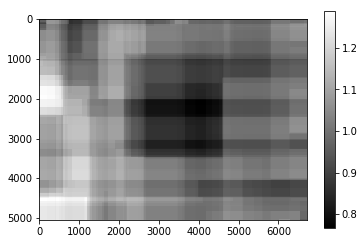

In [48]:
plt.imshow(yp)
plt.colorbar()

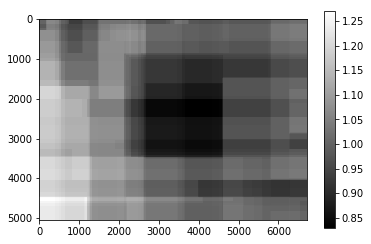

In [42]:
plt.imshow(yp)
plt.colorbar()

In [54]:
plt.set_cmap('viridis')

<Figure size 432x288 with 0 Axes>

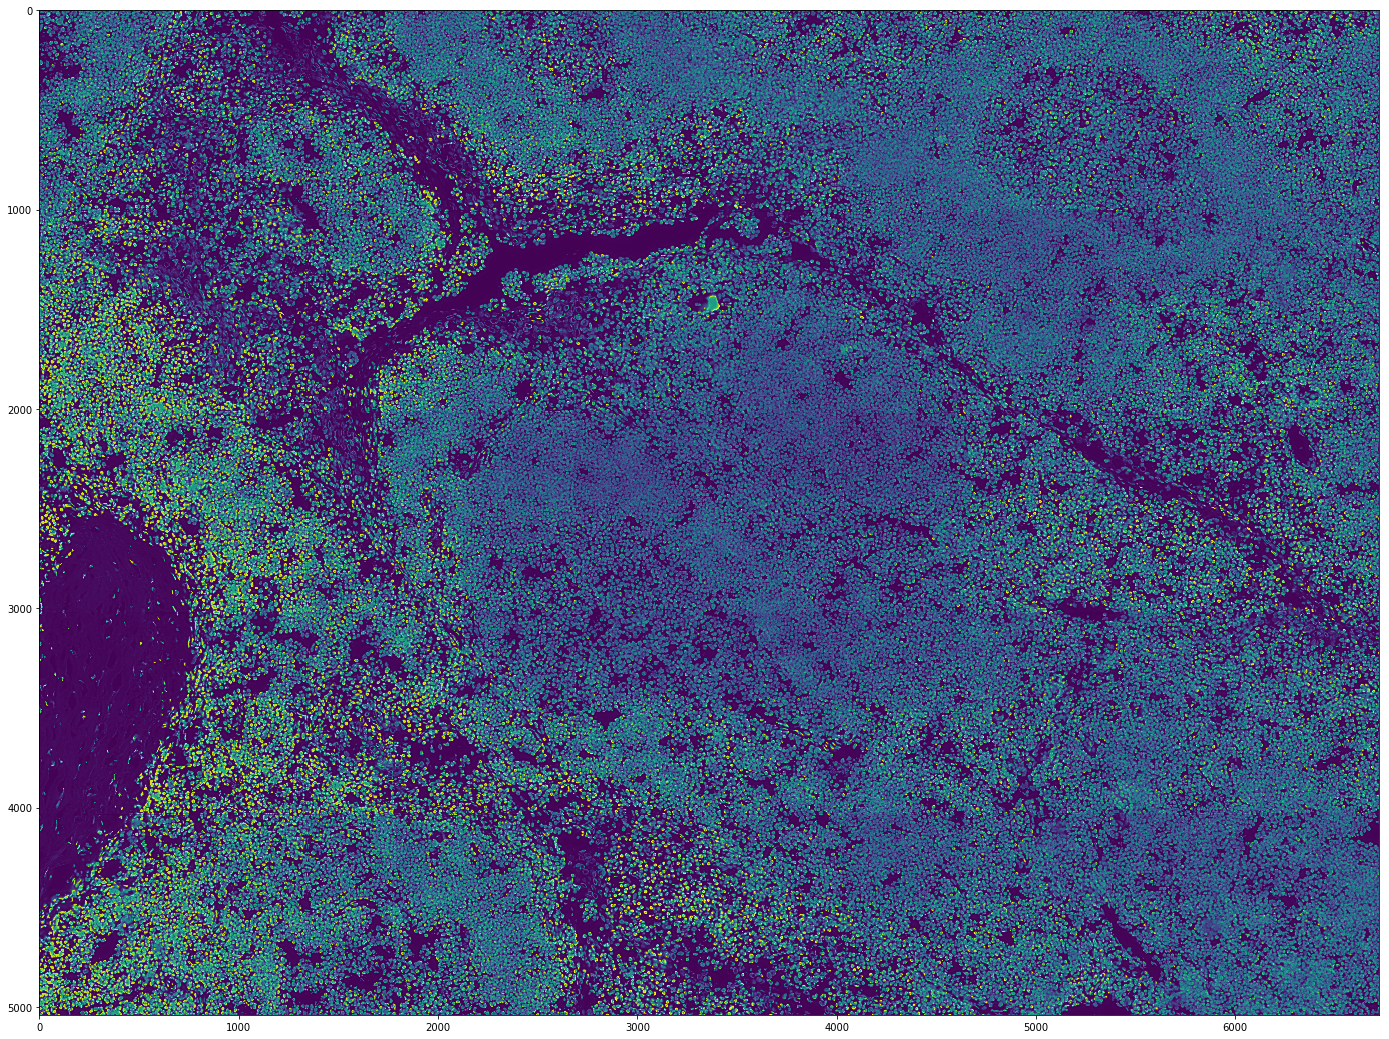

In [55]:
plt.imshow(img[0, 0, 7])
#plt.imshow(img[0, 0, 5])
plt.gcf().set_size_inches(24, 24)

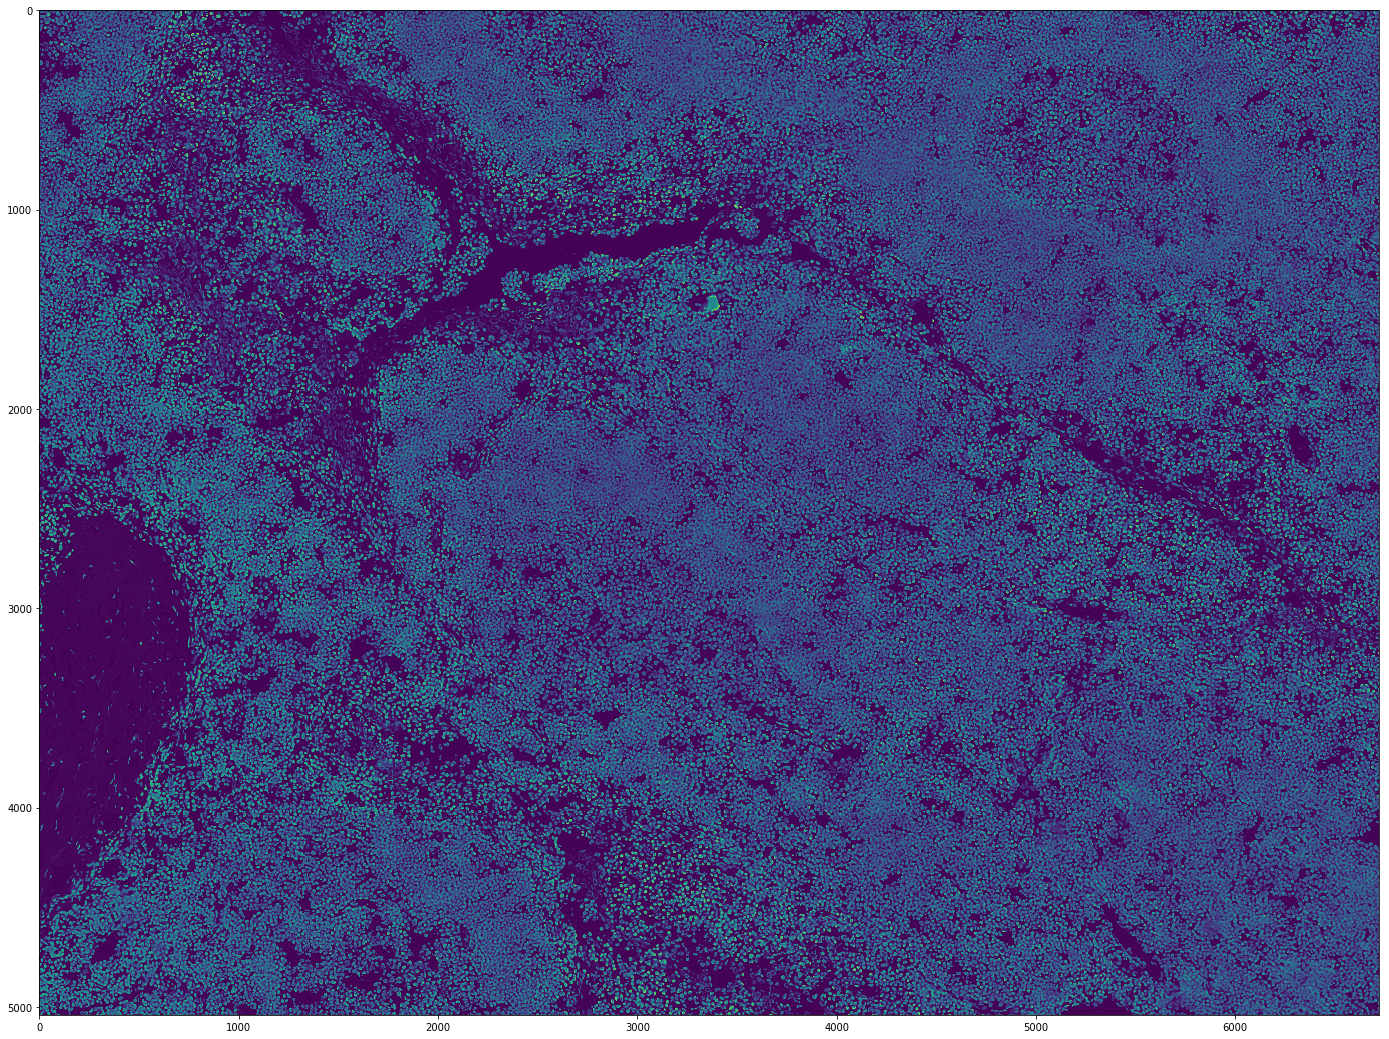

In [56]:
plt.imshow(img[0, 0, 7] / yp)
#plt.imshow(img[0, 0, 5] / yp)
plt.gcf().set_size_inches(24, 24)